## Data Preprocessing

In [5]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [6]:
labels = pd.read_csv('data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [7]:
labels = labels.drop_duplicates('patientId')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [8]:
labels['Target'].value_counts()

,count
Target,
0,20672
1,6012


In [9]:
# separating the classes
clean = labels[labels["Target"] == 0]
disease = labels[labels["Target"] == 1]

In [10]:
clean.shape, disease.shape

((20672, 6), (6012, 6))

In [11]:
# Undersampling the larger class
clean_sample = clean.sample(n=disease.shape[0], random_state=42)
clean_sample.shape

(6012, 6)

In [12]:
# Concatenate the 2 dataframes
new_dataset = pd.concat([clean_sample, disease],axis=0)
new_dataset.shape

(12024, 6)

In [13]:
new_dataset['Target'].value_counts()

,count
Target,
0,6012
1,6012


In [14]:
X = new_dataset['patientId']
y = new_dataset['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
new_dataset.loc[:, 'split'] = 'train'
new_dataset.loc[X_val.index, 'split'] = 'val'

new_dataset.head(6)

,patientId,x,y,width,height,Target,split
28878,ff3263ac-8016-47aa-ac03-4254bf0f2f13,NaN,NaN,NaN,NaN,0,train
13855,8a6a239d-428c-4e35-a479-44272702e98a,NaN,NaN,NaN,NaN,0,train
22813,cdcc882c-4f61-4fcf-ba27-74fc68e60347,NaN,NaN,NaN,NaN,0,train
17800,a961ef19-ab98-4495-868c-cd268ef256f7,NaN,NaN,NaN,NaN,0,val
26670,ed78aad5-54e8-4853-aae8-dcb8f8dc9e79,NaN,NaN,NaN,NaN,0,val
22773,cd770f6b-91a2-4bc7-8efc-f650b98c1f42,NaN,NaN,NaN,NaN,0,val


In [16]:
ROOT_PATH = Path('data/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('processed/rsna-pneumonia-detection-challenge')

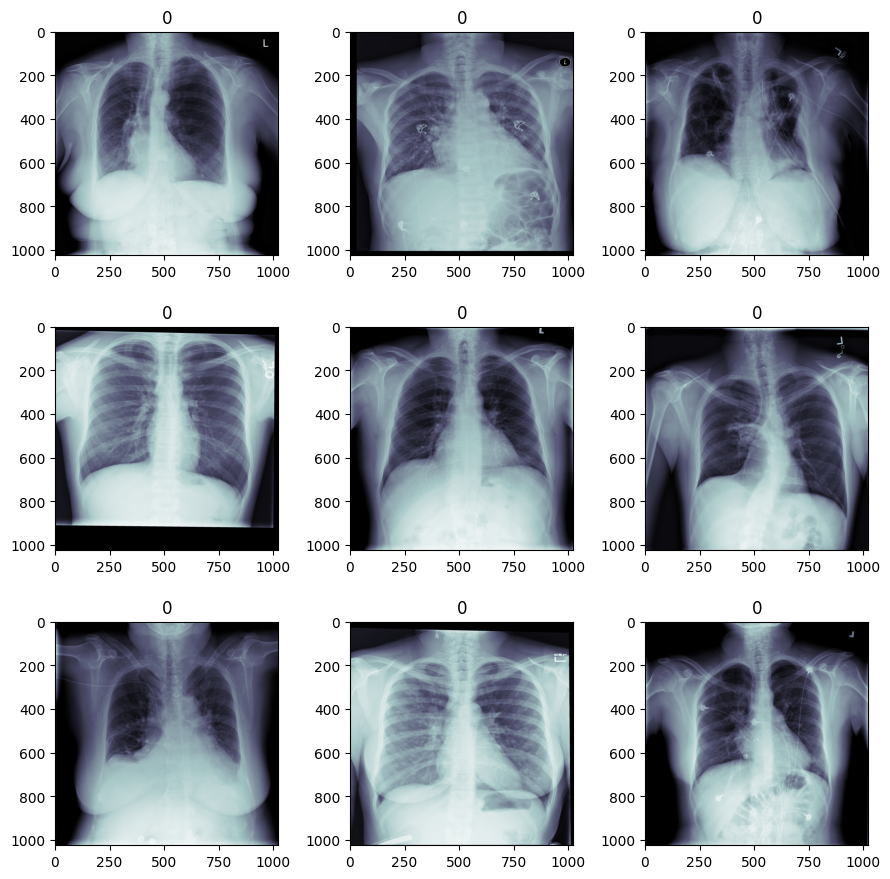

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = new_dataset['patientId'].iloc[c]
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = new_dataset['Target'].iloc[c]

        axes[i][j].imshow(dcm, cmap='bone')
        axes[i][j].set_title(label)
        c += 1

fig.tight_layout()

In [18]:
sums, sums_squared = 0, 0
normalizer = 224 * 224

for c, _ in enumerate(tqdm(new_dataset['patientId'])):
    patient_id = new_dataset['patientId'].iloc[c]
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.read_file(dcm_path).pixel_array / 255 # Standardization

    dcm_array = cv2.resize(dcm, (244,244)).astype(np.float16)
    label = new_dataset['Target'].iloc[c]

    train_or_val = new_dataset['split'].iloc[c]

    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path / patient_id, dcm_array)

    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/12024 [00:00<?, ?it/s]

In [19]:
# Z-Normalization
mean = sums / len(X_train)
std = np.sqrt((sums_squared / len(X_train)) - mean ** 2)

mean, std

(np.float16(0.2131), np.float16(0.3633))

## Data Loading

In [20]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

In [21]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [22]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomAffine(degrees=(-5, 5),
                            translate=(0, 0.05),
                            scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(size=(224, 224),
                                 scale=(0.35, 1),
                                 antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [23]:
train_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/train',
                                       loader=load_file,
                                       extensions='npy',
                                       transform=train_transforms)

val_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/val',
                                     loader=load_file,
                                     extensions='npy',
                                     transform=val_transforms)

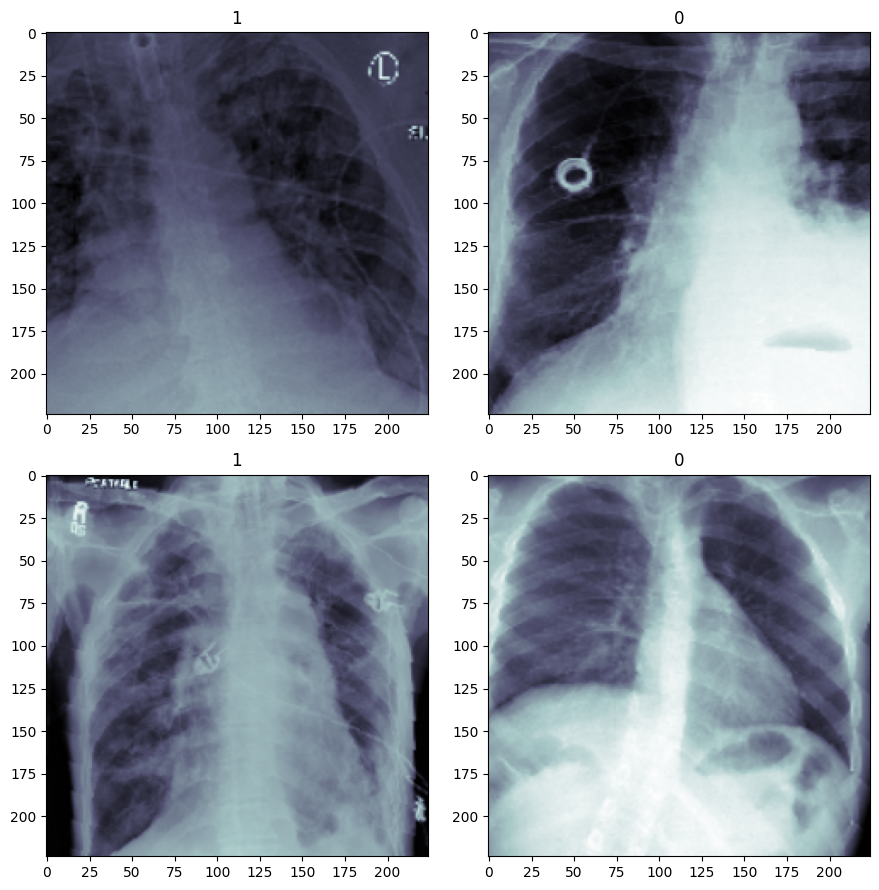

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axes[i][j].imshow(x_ray[0], cmap='bone')
        axes[i][j].set_title(label)

fig.tight_layout()

In [25]:
batch_size = 64
num_workers = os.cpu_count() - 1

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True,
                                               pin_memory=True,
                                               persistent_workers=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=False,
                                             pin_memory=True,
                                             persistent_workers=True)

In [26]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([4809, 4810]))

## Model Creation

In [27]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(in_channels=1,
                                           out_channels=64,
                                           kernel_size=(7, 7),
                                           stride=(2, 2),
                                           padding=(3, 3),
                                           bias=False)
        self.model.fc = torch.nn.Linear(in_features=512,
                                        out_features=1,
                                        bias=True)

        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.train_prec = torchmetrics.Precision(task='binary')
        self.train_rec = torchmetrics.Recall(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        self.val_prec = torchmetrics.Precision(task='binary')
        self.val_rec = torchmetrics.Recall(task='binary')

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0] # As pred shape is (batch_size, 1) while label shape is (batch_size,)
        loss = self.loss_fn(pred, label)

        pred, label = torch.sigmoid(pred), label.int()
        self.log(name='Train Loss', value=loss, prog_bar=True, logger=True)
        self.log(name='Step Train Accuracy', value=self.train_acc(pred, label), prog_bar=True, logger=True)
        self.log(name='Step Train Precision', value=self.train_prec(pred, label))
        self.log(name='Step Train Recall', value=self.train_rec(pred, label))

        return loss

    def on_train_epoch_end(self):
        self.log(name='Train Accuracy', value=self.train_acc.compute(), prog_bar=True, logger=True)
        self.log(name='Train Precision', value=self.train_prec.compute(), prog_bar=True, logger=True)
        self.log(name='Train Recall', value=self.train_rec.compute(), prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0] # As pred shape is (batch_size, 1) while label shape is (batch_size,)
        loss = self.loss_fn(pred, label)

        pred, label = torch.sigmoid(pred), label.int()
        self.log(name='Validation Loss', value=loss, prog_bar=True, logger=True)
        self.log(name='Step Validation Accuracy', value=self.val_acc(pred, label))
        self.log(name='Step Validation Precision', value=self.val_prec(pred, label))
        self.log(name='Step Validation Recall', value=self.val_rec(pred, label))

    def on_validation_epoch_end(self):
        self.log(name='Validation Accuracy', value=self.val_acc.compute(), prog_bar=True, logger=True)
        self.log(name='Validation Precision', value=self.val_prec.compute(), prog_bar=True, logger=True)
        self.log(name='Validation Recall', value=self.val_rec.compute(), prog_bar=True, logger=True)

    def configure_optimizers(self):
        return [self.optimizer]

In [47]:
pl.seed_everything(42)

model = PneumoniaModel()

checkpoint_callback = ModelCheckpoint(monitor='Validation Accuracy',
                                      verbose=True,
                                      save_last=True,
                                      save_top_k=10,
                                      mode='max') # Saves checkpoints based on highest accuracy instead of lowest

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [48]:
trainer = pl.Trainer(accelerator='auto',
                     devices='auto',
                     logger=TensorBoardLogger(save_dir='logs'),
                     log_every_n_steps=1,
                     callbacks=[checkpoint_callback],
                     max_epochs=35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/last.ckpt
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from 'logs/lightning_logs/version_0/checkpoints' to 'logs/lightning_logs/version_1/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | ResNet            | 11.2 M | train
1 | loss_fn    | BCEWithLogitsLoss | 0      | train
2 | train_acc  | BinaryAccuracy    | 0      | train
3 | train_prec | BinaryPrecision   | 0      | train
4 | train_rec  | BinaryRecall    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [32]:
model = PneumoniaModel.load_from_checkpoint('logs/lightning_logs/version_0/checkpoints/last.ckpt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
model.to(device);

In [33]:
preds = []
labels = []

with torch.inference_mode():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2405 [00:00<?, ?it/s]

In [34]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
f1 = (2 * precision * recall) / (precision + recall)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)

print(f'Validation Accuracy: {acc}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1-Score: {f1}')
print(f'Confusion Matrix:\n{cm}')

Validation Accuracy: 0.7733888030052185
Validation Precision: 0.7989081144332886
Validation Recall: 0.7304492592811584
Validation F1-Score: 0.7631464600563049
Confusion Matrix:
tensor([[982, 221],
        [324, 878]])


## Knowledge Interpretation

In [35]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [37]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/val',
                                     loader=load_file,
                                     extensions='npy',
                                     transform=val_transforms)

In [38]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [40]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [41]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(in_channels=1,
                                           out_channels=64,
                                           kernel_size=(7, 7),
                                           stride=(2, 2),
                                           padding=(3, 3),
                                           bias=False)
        self.model.fc = torch.nn.Linear(in_features=512,
                                        out_features=1,
                                        bias=True)

        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map,
                                                                  output_size=(1, 1))
        avg_output_flatten = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flatten)

        return pred, feature_map

In [ ]:
model = PneumoniaModel.load_from_checkpoint('logs/lightning_logs/version_0/checkpoints/last.ckpt', strict=False) # As we have changed the model architecture to that of before training
model.eval();

In [43]:
def cam(model, img):
    with torch.inference_mode():
        pred, features = model(img.unsqueeze(0))

    features = features.reshape((512, -1))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(8, 8).cpu()

    return cam_img, torch.sigmoid(pred)

In [44]:
def visualize(img, cam, pred, label):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()

    axes[0].imshow(img, cmap='bone')
    axes[0].set_title(label)

    axes[1].imshow(img, cmap='bone')
    axes[1].imshow(cam, alpha=0.5, cmap='jet')
    axes[1].set_title((pred > 0.5)[0])

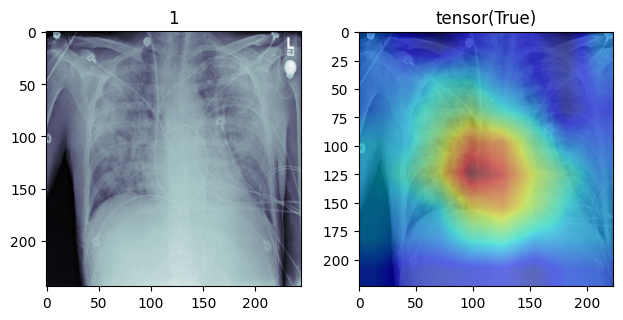

In [45]:
img = val_dataset[-6][0]
label = val_dataset[-6][1]
activation_map, pred = cam(model.to('cpu'), img)

visualize(img, activation_map, pred, label)